# Gerando IPTU espacializado por pontos e agregados por distrito para todos exercícios

In [34]:
import vaex
import pandas as pd
import geopandas as gpd
from shapely.validation import make_valid
from difflib import SequenceMatcher
import numpy as np
import pandas as pd

In [27]:
df = vaex.open(f'data/IPTU_2022/IPTU_2022.hdf5')#.to_pandas_df()
gdf_distrito = gpd.read_file('data/SIRGAS_GPKG_distrito.gpkg')

In [28]:
df.setor = df['NUMERO DO CONTRIBUINTE'].str.slice(0,3)
df.quadra = df['NUMERO DO CONTRIBUINTE'].str.slice(3,6)
df.fillna(value='00-0', column_names=['NUMERO DO CONDOMINIO'], inplace=True)
df.fillna(value=1., column_names=['FRACAO IDEAL'], inplace=True)
df.fillna(value=0., column_names=['AREA CONSTRUIDA', 'AREA OCUPADA', 'AREA DO TERRENO'], inplace=True)
df.sqlc = df.func.where(df['NUMERO DO CONDOMINIO'] == '00-0',
                                df['NUMERO DO CONTRIBUINTE'].str.slice(0, 10) + '00',
                                df['NUMERO DO CONTRIBUINTE'].str.slice(0, 6) + '0000' + df['NUMERO DO CONDOMINIO'].str.slice(0, 2))
df['sq'] = df.setor + df.quadra
df['sqlc'] = df.sqlc

In [29]:
df = df.to_pandas_df()

In [4]:
gdf_lote = gpd.read_file(f'zip://data/lotes/SIRGAS_SHP_LOTES_90_VILA_MARIANA.zip!SIRGAS_SHP_LOTES_90_VILA_MARIANA/SIRGAS_SHP_LOTES_90_VILA_MARIANA.shp')

In [5]:
gdf_lote = gdf_lote[gdf_lote.lo_tp_lote == 'F']

In [6]:
gdf_lote['sqlc'] = gdf_lote.lo_setor + gdf_lote.lo_quadra + gdf_lote.lo_lote + gdf_lote.lo_condomi
gdf_lote['sq'] = gdf_lote.lo_setor + gdf_lote.lo_quadra 
gdf_lote['geometry'] = gdf_lote.representative_point()

In [7]:
gdf_lote

,lo_setor,lo_quadra,lo_lote,lo_condomi,lo_tp_quad,lo_tp_lote,geometry,sqlc,sq
0,042,067,0000,08,F,F,POINT (332080.671 7389398.255),042067000008,042067
1,037,056,0000,07,F,F,POINT (333037.858 7390154.381),037056000007,037056
2,039,025,0000,06,F,F,POINT (334986.635 7391299.199),039025000006,039025
3,038,089,0000,05,F,F,POINT (333706.667 7391245.012),038089000005,038089
4,039,082,0000,09,F,F,POINT (333990.193 7390290.401),039082000009,039082
...,...,...,...,...,...,...,...,...,...
16453,037,040,0000,05,F,F,POINT (332566.590 7390580.862),037040000005,037040
16454,037,040,0000,04,F,F,POINT (332808.596 7390692.502),037040000004,037040
16455,039,158,0000,21,F,F,POINT (333808.730 7390280.822),039158000021,039158
16456,036,048,0000,15,F,F,POINT (332082.997 7391767.759),036048000015,036048


<AxesSubplot:>

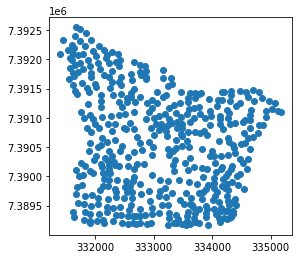

In [8]:
gdf_lote.dissolve(by=['lo_setor', 'lo_quadra']).representative_point().plot()

In [ ]:
## Para cada ano de IPTU
    ## Para cada distrito
        ## Join dos dados de IPTU com lotes pelo SQLC, atribuindo um campo espaciliazaco pelo lote (BOOL)
        ## Com o refugo, espacializar pelo ponto representativo da dissolucao dos polĩgonoes do refugo
        ## Salva o arquivo em GPKG

In [63]:
for i, distrito in gdf_distrito.iterrows():
    
    d_nome, d_codigo = distrito.ds_nome.replace(" ", "_"), distrito.ds_codigo

    gdf_lote = gpd.read_file(f'zip://data/lotes/SIRGAS_SHP_LOTES_{d_codigo}_{d_nome}.zip!SIRGAS_SHP_LOTES_{d_codigo}_{d_nome}/SIRGAS_SHP_LOTES_{d_codigo}_{d_nome}.shp')
    ## TODO Considerar o lote condominial
    gdf_lote['sqlc'] = gdf_lote.lo_setor + gdf_lote.lo_quadra + gdf_lote.lo_lote + gdf_lote.lo_condomi
    gdf_lote['sq'] = gdf_lote.lo_setor + gdf_lote.lo_quadra 
    gdf_lote['geometry'] = gdf_lote.representative_point()

    df_sqlc = df.merge(gdf_lote, how='left', on='sqlc')
    df_sq = df[df_sqlc.lo_lote.isna()].merge(gdf_lote, how='left', on='sq')

    ## TODO - Concatenar df_sqlc com df_sq
    ## TODO - Salvar o resultado
    
    break

## TODO - criar interação sobre cada ano

In [66]:
df_sqlc.lo_lote.isna().value_counts(), df_sq.lo_lote.isna().value_counts()

(True     3538799
 False      41392
 Name: lo_lote, dtype: int64,
 True     3533521
 False     181262
 Name: lo_lote, dtype: int64)